# Perform Sanity-Check of EOR-GRF visibility sims before chunking

In this notebook, we check the EOR-GRF sims to ensure they have the correct power spectrum for a selection of baselines.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import sys
import pyuvdata
import matplotlib.pyplot as plt
import hera_pspec as hp
import h5py
from pyuvdata.uvdata import FastUVH5Meta
import copy

sys.path.append("..")
from core import eor_utils, utils


In [2]:
# DEFAULT PARAMETERS
SKY_MODEL: str = "eor-grf-1024-monopole"
SKY_MONO: str = "eor-grf-1024-only-monopole"
PREFIX: str = "matvis-paper"
CHUNKS: int = 17280
LAYOUT: str = "HERA19"
REDUNDANT: bool = False

BAND: tuple[int, int] = (575, 706)

## Setup

In [3]:
direc = utils.OUTDIR / utils.get_direc(SKY_MODEL, CHUNKS, LAYOUT, REDUNDANT, PREFIX)
files = sorted(direc.glob("*.uvh5"))

# # down-select to specified band
files = [fl for fl in files if BAND[0] <= utils.parse_fname(fl.stem)['fch'] < BAND[1]]

In [4]:
direc = utils.OUTDIR / utils.get_direc(SKY_MONO, CHUNKS, LAYOUT, REDUNDANT, PREFIX)
mono_files = sorted(direc.glob("*.uvh5"))

# # down-select to specified band
mono_files = [fl for fl in mono_files if BAND[0] <= utils.parse_fname(fl.stem)['fch'] < BAND[1]]

In [5]:
len(files), len(mono_files)

(131, 131)

In [6]:
meta = FastUVH5Meta(files[0])

In [7]:
NTIMES = 1

In [8]:
blidx = np.array(list(range(meta.Nbls)))

## Obtain Power Spectrum Definition

In [9]:
cosmo = eor_utils.get_planck15_cosmo()

In [10]:
# Load beam-dependent normalization data
omegas_data_path = utils.BEAMDIR / 'vivaldi_solid_angle_and_reciever_power.h5'

with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['directivity_integral'][()]
    Omegapp = h5f['directivity_square_integral'][()]
    
# hera_pspec beam initiated from pre-computed integral data
hpsb = hp.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, utils.FREQS_DICT['H4C'], cosmo=cosmo)

In [11]:
pspec_def = eor_utils.get_pspec_from_covariance_file(utils.SKYDIR / 'raw' / 'covariance.h5')

## Read Data

In [12]:
pyuvdata_nocheck = {
    'run_check': False,
    'check_extra': False,
    'run_check_acceptability': False,
    'strict_uvw_antpos_check': False,
    'check_autos': False,
    'fix_autos': False
}

We read only a single time-stamp here, and only the baselines we care about. This dramatically speeds up reading.

In [13]:
blt_idx = np.concatenate([blidx + i*meta.Nbls*1 for i in range(NTIMES)])

In [14]:
def get_uvd_base():
    uvd = pyuvdata.UVData.from_file(files[0], blt_inds=blt_idx, **pyuvdata_nocheck)
    uvd.freq_array = utils.FREQS_DICT['H4C'][BAND[0]:BAND[1]]

    dd = uvd.data_array.copy()

    uvd.data_array = np.zeros((dd.shape[0], BAND[1] - BAND[0], dd.shape[2]), dtype=complex)
    uvd.data_array[:, 0, :] = dd[:, 0]

    # Re-set arrays that reference Nfreqs
    uvd.nsample_array = np.ones(uvd.data_array.shape, dtype=float)
    uvd.flag_array = np.zeros(uvd.data_array.shape, dtype=bool)
    uvd.Nfreqs = BAND[1] - BAND[0]
    uvd.channel_width = np.ones(BAND[1] - BAND[0]) * (uvd.freq_array[1] - uvd.freq_array[0])
    uvd.flex_spw_id_array = np.zeros(BAND[1] - BAND[0], dtype=int)
    uvd.pol_convention='sum'
    return uvd

In [15]:
uvd = get_uvd_base()
uvd_nonsub = get_uvd_base()

antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.


In [16]:
%%time
for i, (fl, mono) in enumerate(zip(files, mono_files)):
    with h5py.File(fl, 'r') as _fl:
        dd = _fl['Data']['visdata'][blt_idx, 0, :]
    with h5py.File(mono, 'r') as _fl:
        mm = _fl['Data']['visdata'][blt_idx, 0, :]
    
    uvd.data_array[:, i] = dd - mm
    uvd_nonsub.data_array[:, i] = dd

CPU times: user 207 ms, sys: 87.5 ms, total: 295 ms
Wall time: 8.52 s


In [17]:
uvd.check()
uvd_nonsub.check()

True

## Compute Power Spectra from Data

In [18]:
uvd_pstokes = hp.pstokes.construct_pstokes(uvd, uvd, pstokes='pI', run_check=False)
ds = hp.PSpecData(dsets=[uvd_pstokes, uvd_pstokes], beam=hpsb)
ds.Jy_to_mK()

uvd_nonsub_pstokes = hp.pstokes.construct_pstokes(uvd_nonsub, uvd_nonsub, pstokes='pI', run_check=False)
ds_nonsub = hp.PSpecData(dsets=[uvd_nonsub_pstokes, uvd_nonsub_pstokes], beam=hpsb)
ds_nonsub.Jy_to_mK()

Cannot convert dset 1 Jy -> mK because vis_units = mK
Cannot convert dset 1 Jy -> mK because vis_units = mK


In [19]:
ant_pairs = [ant_pair for ant_pair in uvd.get_antpairs() if ant_pair[0] != ant_pair[1]]
spw_ranges = [(0, BAND[1] - BAND[0])] # use the full band, since we already down-selected

uvp = ds.pspec(
    ant_pairs, ant_pairs,
    dsets=(0,1),
    pols=('pI', 'pI'),
    input_data_weight='identity',
    norm='I',
    taper='blackman-harris',
    spw_ranges=spw_ranges,
    store_window=False,
    verbose=True,
    allow_fft=True,
    exact_norm=False
)

uvp_nonsub = ds_nonsub.pspec(
    ant_pairs, ant_pairs,
    dsets=(0,1),
    pols=('pI', 'pI'),
    input_data_weight='identity',
    norm='I',
    taper='blackman-harris',
    spw_ranges=spw_ranges,
    store_window=False,
    verbose=True,
    allow_fft=True,
    exact_norm=False
)

# time average for each (delay, baseline)
uvp.average_spectra(time_avg=True, inplace=True)

# time average for each (delay, baseline)
uvp_nonsub.average_spectra(time_avg=True, inplace=True)

In [20]:
k_bin_widths = 0.05
k_bins = np.arange(0,2.0,k_bin_widths)

In [21]:
%%time

uvp_sphr = copy.deepcopy(uvp)

# average over (delay, baseline) for each k
uvp_sphr = hp.grouping.spherical_average(uvp_sphr, k_bins, k_bin_widths, run_check=False)

uvp_nonsub_sphr = copy.deepcopy(uvp_nonsub)

# average over (delay, baseline) for each k
uvp_nonsub_sphr = hp.grouping.spherical_average(uvp_nonsub_sphr, k_bins, k_bin_widths, run_check=False)

CPU times: user 1.29 s, sys: 11.7 ms, total: 1.3 s
Wall time: 733 ms


In [42]:
len(uvp.get_all_keys())

30

In [45]:
from pyuvdata.utils import redundancy

In [55]:
ubls, _, _ = redundancy.get_antenna_redundancies(np.arange(uvd.telescope.Nants), uvd.telescope.antenna_positions, use_grid_alg=True)

In [56]:
len(ubls)

30

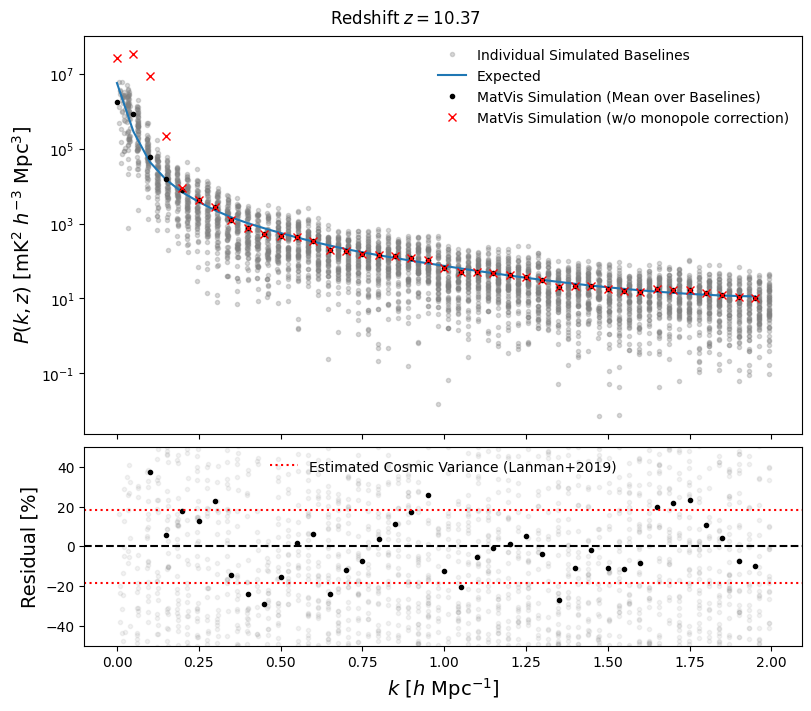

In [65]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(8,7), constrained_layout=True, gridspec_kw={"hspace": 0.0, 'height_ratios': [2, 1]})


littleh = True

z_mean = np.mean(eor_utils.get_zs(cosmo, uvp, 0))

# Each baseline
for i, key in enumerate(uvp.get_all_keys()):
    kmag = np.sqrt(uvp.get_kparas(0)**2 + uvp.get_kperps(0)[i]**2)
    d = uvp.get_data(key)[0].real
    ax[0].plot(kmag, d, '.', color='gray', alpha=0.3, label='Individual Simulated Baselines' if i==0 else None)

pspec_true = eor_utils.true_power_spectrum(cosmo, pspec_def, k_bins[1:], z_mean, rescale_idx=0, littleh=littleh)
pspec_expected = eor_utils.expected_power_spectrum(cosmo, pspec_def, k_bins, uvp, spw=0, rescale_idx=0, littleh=littleh)

# ax[0].plot(k_bins[1:], pspec_true, label='true power spectrum', color='tab:red')
ax[0].plot(k_bins, pspec_expected, label='Expected', color='tab:blue')


# The average over all baselines
key = uvp_sphr.get_all_keys()[0]
pspec_est = uvp_sphr.get_data(key)[0].real
ax[0].plot(k_bins, pspec_est, '.', label=f'MatVis Simulation (Mean over Baselines)', color='k')

key = uvp_nonsub_sphr.get_all_keys()[0]
pspec_est = uvp_nonsub_sphr.get_data(key)[0].real
ax[0].plot(k_bins, pspec_est, 'x', label=f'MatVis Simulation (w/o monopole correction)', color='r')


ax[0].set_yscale('log')
ax[0].set_ylabel(r'$P(k,z)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)


plt.xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
fig.suptitle(fr'Redshift $z ={z_mean:.2f}$')

#plt.grid()
ax[0].legend(frameon=False);


# RESIDUAL PANEL

cvar = 100 / np.sqrt(len(ubls))


# Each baseline
for i, key in enumerate(uvp.get_all_keys()):
    kmag = np.sqrt(uvp.get_kparas(0)**2 + uvp.get_kperps(0)[i]**2)
    d = uvp.get_data(key)[0].real
    pspec_expected_kmag = eor_utils.expected_power_spectrum(cosmo, pspec_def, kmag, uvp, spw=0, rescale_idx=0, littleh=littleh)

    ax[1].plot(kmag, 100*(d - pspec_expected_kmag)/pspec_expected_kmag, '.', color='gray', alpha=0.1)

# The average over all baselines
key = uvp_sphr.get_all_keys()[0]
pspec_est = uvp_sphr.get_data(key)[0].real

ax[1].axhline(0, color='k', ls='--')
ax[1].set_ylim(-50, 50)
ax[1].plot(k_bins, 100* (pspec_est - pspec_expected)/pspec_expected, '.', color='k')
ax[1].set_ylabel("Residual [%]", fontsize=14)

ax[1].axhline(-cvar, color='r', ls=':', label='Estimated Cosmic Variance (Lanman+2019)')
ax[1].axhline(cvar, color='r', ls=':')
ax[1].legend(frameon=False)

In [59]:
np.sqrt(cvar) / pspec_expected

array([7.68981237e-05, 3.39719657e-04, 8.66508158e-04, 1.49798930e-03,
       2.21525137e-03, 2.96929185e-03, 3.84566846e-03, 4.78161462e-03,
       5.71578961e-03, 6.67631935e-03, 7.71605879e-03, 8.85562879e-03,
       1.00797287e-02, 1.13560213e-02, 1.26560120e-02, 1.39682016e-02,
       1.52997913e-02, 1.66700093e-02, 1.81013070e-02, 1.96127532e-02,
       2.12166664e-02, 2.29177236e-02, 2.47135102e-02, 2.65957876e-02,
       2.85520701e-02, 3.05672532e-02, 3.26250680e-02, 3.47091448e-02,
       3.68035027e-02, 3.88923793e-02, 4.09594353e-02, 4.29864973e-02,
       4.49521030e-02, 4.68301784e-02, 4.85892102e-02, 5.01922742e-02,
       5.15982159e-02, 5.27641319e-02, 5.36490377e-02, 5.42182607e-02])